# Devoir 3 : Image Panoramique


## 1. Initialisation


In [2]:
from __future__ import print_function

# Setup
import numpy as np
from skimage.io import imread
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## 2. Description

Ce devoir traite la transformation de l'image, la méthode robuste RANSAC, la projection bilineaire inverse et la fusion d'images dans un panorama.

L'assemblage d'images en panorama est un très grand succès de la vision par ordinateur. Matthew Brown et David G. Lowe ont publié un célèbre [article](https://drive.google.com/file/d/1qB54hR4TS_7But2KKkvuk6jTV1uWg8Tf/view?usp=sharing) sur cette technique en 2007. Depuis lors, cette technologie a été largement adoptée dans de nombreuses applications telles que "**Google Street View**", les photos panoramiques sur les smartphones et les logiciels d'assemblage tels que **Photosynth** et **AutoStitch**. 

Dans ce devoir, vous allez mettre en oeuvre un système pour combiner une série d'images se chevauchant en une seule image panoramique. Les fonctions ORB de OpenCV sont utilisées pour la détection des points-clés dans les images et fournissent un appariement initial.

Dans un premier temps, vous allez implémenter le code qui calcule la matrice de transformation entre deux images à partir des paires de correnspondance de points-clés dans ces images. Ensuite, et à l'aide de RANSAC, vous allez séparer les bonnes correspondances (inliers) des mauvaises (outliers) afin d'aligner automatiquement les images et déterminer leurs chevauchements ainsi que leurs positions relatives les unes par rapport aux autres. 
L'étape suivante, pour chaque image à transformer, utilisez la transformation retournée par RANSAC pour implémenter la projections bilineaire inverse dans l'image destination.
Enfin, fusionnerez les images résultantes en un seul panorama homogène. 

Les étapes requises pour créer un panorama sont indiquées ci-dessous. Celles que vous devez implémenter sont indiquées en gras : 

1. Extraire les primitives dans les images
2. Mise en correspondance des primitives
3. **Calcul de la matrice de transformation**
4. **Alignement des images à l'aide de RANSAC**
5. **Projection et interpolation des images**
4. **Fusion des images dans un panorama**

Pour vous aider à démarrer dans ce devoir, ce bloc-notes contient des tests et/ou affiche les résultats attendus pour l'exemple d'images utilisées.

## 3. Règles de codage

**<span style='color:Red'>
NE MODIFIEZ PAS LE CODE SQUELETTE EN DEHORS DES BLOCS TODO.<br>L'EVALUATEUR AUTOMATIQUE SERA TRES MECHANT AVEC VOUS SI VOUS LE FAITES !
</span>**

### 3.1. Résumé des fonctions potentiellement utiles (vous n'êtes pas obligé de les utiliser)  
- np.divide, 
- np.eye, 
- np.ndarray, 
- np.dot, 
- np.linalg.svd, 
- np.linalg.inv

### 3.2. Résumé des fonctions <span style='color:Red'>interdites</span>
- cv2.findHomography,
- cv2.perspectiveTransform,
- cv2.warpPerspective,
- cv2.remap,
- cv2.getAffineTransform,
- cv2.getPerspectiveTransform,
- cv2.invertAffineTransform,
- cv2.warpAffine,
- skimage.transform.ProjectiveTransform,
- skimage.measure.ransac,
- skimage.transform.SimilarityTransform,
- skimage.transform.AffineTransform,
- skimage.transform.FundamentalMatrixTransform,
- skimage.transform.warp,
- skimage.transform.warp_coords

Vous pouvez utiliser ces fonctions pour le débogage de votre code, mais la version finale ne doit en aucun cas les inclure faute d'avoir un zéro pour le devoir.


## 4. Préparation des données

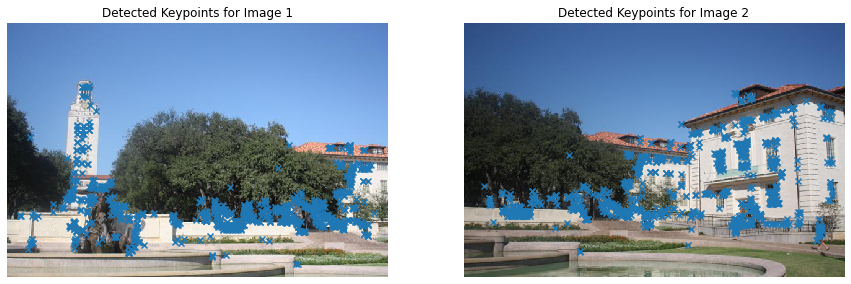

In [3]:
# Commençant par charger deux images
img1 = imread('resources/uttower/uttower1.jpg')
img2 = imread('resources/uttower/uttower2.jpg')
imgs = [img1, img2]

# construisons l'objet orb pour la detection, description 
# et mise en correnspondance par la méthode ORB
orb = ORB(n_keypoints=1000, fast_threshold=0.05)
  
# détection des points-clés et construction des
# descripteurs associés
keypoints_list   = []  # keypoints[i] corresponds to imgs[i]
descriptors_list = []  # descriptors[i] corresponds to keypoints[i]
for img in imgs:    
    orb.detect_and_extract(rgb2gray(img))
    keypoints = orb.keypoints
    descriptors = orb.descriptors

    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Affichage des points-clés détectés    
keypoints1 = keypoints_list[0]
keypoints2 = keypoints_list[1]

plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()


Le code suivant effectue la mise en correspondance des deux images et affiche l'ensemble des correspondances détectées 

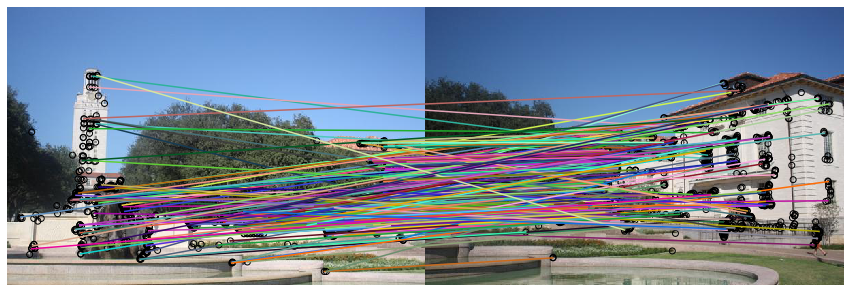

In [4]:
from utils import plot_matches

matches_list = []  # matches_list[i] décrit la paire de correspondance entre les descripteurs descriptors[i] et descriptors[i+1]
for i in range(len(imgs)-1):
    matches = match_descriptors(descriptors_list[i], descriptors_list[i+1], cross_check=True)        
    matches_list.append(matches)

# traçons les correspondances...
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()

## 5. Les tâches

### 5.1. Estimation de la matrice de transformation [TODO 1] (20 points)

Nous avons maintenant une liste de points clés correspondants sur les deux images. Nous allons l'utiliser pour trouver une matrice de transformation qui mappe les points de la première image aux coordonnées correspondantes dans la deuxième image. En d'autres termes, si le point $p_1 = [y_1,x_1]$ dans l'image 1 correspond à $p_2=[y_2, x_2]$ dans l'image 2, nous devons trouver une matrice de transformation $H$ telle que

$$
\tilde{p_1}{H}^T = \tilde{p_2},
$$

où $\tilde{p_1}$ et $\tilde{p_2}$ sont des coordonnées homogènes de $p_1$ et $p_2$.

Notez qu'il peut être impossible de trouver la transformation $H$ qui mappe chaque point de l'image 1 **exactement** au point correspondant de l'image 2. Cependant, nous pouvons estimer la matrice de transformation avec les moindres carrés ou la décomposition en valeurs singulières. Étant donné $N$ paires de points-clés correspondants, soit $X_1$ et $X_2$ des matrices $N \times 3$ dont les lignes sont des coordonnées homogènes des points clés correspondants dans l'image 1 et l'image 2 respectivement. Nous pouvons estimer $H$ en résolvant le problème des moindres carrés,

$$
X_1 {H}^T = X_2
$$

Implémentez **`fit_transform_matrix`** dans` panorama.py`

*- Indication : lisez les documentations sur [np.linalg.lstsq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)* et [np.linalg.svd](https://numpy.org/doc/1.18/reference/generated/numpy.linalg.svd.html)

In [5]:
from panorama import fit_transform_matrix

# test de validité pour fit_transform_matrix

# test donnée en entrée 
a = np.array([[0.0, 0.0], 
              [0.0, 1.0], 
              [1.0, 0.0], 
              [1.0, 1.0]])

# test donnée en sortie
v = np.sqrt(2)/2
b = np.array([[ 0.0, 0.0],
              [   v,   v],
              [   v,  -v],
              [ v+v, 0.0]])

# premier test
H1 = fit_transform_matrix(a, a)
H1 = H1 / H1[2,2]
# sortie attendue
sol1 = np.eye(3)

#second test
H2 = fit_transform_matrix(a, b)
H2 = H2 / H2[2,2]
# sortie attendue
sol2 = np.array([[v, -v, 0],
                 [v,  v, 0],
                 [0,  0, 1]])

# comparaison des résultats
if np.allclose(sol1, H1, rtol=1e-05, atol=1e-05) and np.allclose(sol2, H2, rtol=1e-05, atol=1e-05):
    print('Implémentation correcte ! ')
else:    
    print('Implémentation uncorrecte !\nH1 = %s, \n\nH2 = %s' % (H1,H2))
    
    

/home/imene/Downloads/hw2/panorama.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H = np.linalg.lstsq(p0,p1)


TypeError: 'tuple' object does not support item assignment

### 5.2. Alignement des images à l'aide de RANSAC [TODO 2] (20 points)
Plutôt que d'utiliser directement toutes nos correspondances de points-clés commen entrées pour la fonction `fit _transform_ matrix`, nous pouvons plutôt utiliser RANSAC (["RANdom SAmple Consensus"](https://en.wikipedia.org/wiki/Random_sample_consensus)) pour sélectionner uniquement les bonnes correspondances (inliers) à utiliser pour calculer la matrice de transformation.

Les étapes de RANSAC sont:
    1. Sélectionner un ensemble aléatoire de correspondances
    2. Caluler la matrice de transformation
    3. Trouver les bonnes correspondances (inliers) en utilisant le seuil donné
    4. Répéter le processus et conserver le plus grand nombre de bonne correspondances
    5. Recalculer l’estimation par les moindres carrés de la matrice de transformation 
       en utilisant que les bonnes correspondances

Implémentez **`ransac`** dans` panorama.py`. Puis, exécutez le code suivant pour obtenir la matrice de transformation robuste $H$ et l'ensemble des bonnes correspondances détectés par RANSAC.

In [ ]:
from panorama import ransac

# choix de seed  pour pouvoir comparer le résultat retourné par ransac 
# par rapport à la solution affichée
np.random.seed(131)

H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Visualisation des correspondances robustes
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('RANSAC_solution.png', as_gray=True))
plt.axis('off')
plt.title('RANSAC Solution')
plt.show()

### 5.3. Projection inverse des images et interpolation bilineaire [TODO3] (40 points)

Nous pouvons maintenant utiliser la matrice de transformation $H$ calculée à l'aide de RANSAC pour transformer nos images et créer un panorama ! En ce sens, implémentez la fonction **`warp_image`** dans `panorama.py`. Vous devez implémenter la procédure de projection inverse avec une interpolation bilinéaire ! C-à-d. Pour transformer les pixels de l'image source, vous commencerez à partir des coordonnées de l'image destination et vous utiliserez l'interpolation bilinéaire dans l'image source pour calculer les couleurs des pixels de l'image destination. 

Une fois cela fait, exécutez le code suivant pour l'appliquer à nos images. Les images seront déformées et l'image 1 sera projetée sur l'image 2.

*Indications :*
- *Lorsque vous manipulez des coordonnées homogènes, n'oubliez pas de normaliser lorsque vous les reconvertissez en coordonnées cartésiennes*. 
- *Attention aux points en dehors de l'image source lors de la projection inverse. Vous ne voudriez pas les inclure dans vos calculs*. 
- *Essayez d'abord de travailler sur le code en bouclant sur chaque pixel (approche classique). Plus tard, vous pouvez optimiser votre code en utilisant des instructions et des astuces numpy (numpy.meshgrid)*.


In [ ]:
from panorama import get_output_space, warp_image

transforms = [H , np.eye(3) ]

# La fonction get_ output_space est une fonction auxiliaire qui aide 
# à trouver le cadre englobant une liste d'images transformées
output_shape, offset = get_output_space(imgs, transforms)

img1_warped, _ = warp_image(imgs[0], transforms[0], output_shape, offset)
img2_warped, _ = warp_image(imgs[1], transforms[1], output_shape, offset)

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped[:,:,:3])
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped[:,:,:3])
plt.title('Image 2 warped')
plt.axis('off')
plt.show()

plt.imshow(imread('warp_image_solution.png', as_gray=True))
plt.axis('off')
plt.title('warp_image Solution')
plt.show()

Maintenant que tous les ingrédients sont là, exécutez le code suivant pour fusionner les deux images transformées avec un mélange moyen des alphas pour obtenir un panorma. Votre panorama peut ne pas sembler bon à ce stade, mais nous utiliserons plus tard d'autres techniques pour obtenir un meilleur résultat.

In [ ]:
alpha1 = img1_warped[:,:,3]
alpha2 = img2_warped[:,:,3]
merged =  img1_warped[:,:,:3] + img2_warped[:,:,:3]

# Track the overlap by adding the masks together
overlap = alpha1 + alpha2

# Normalize through division by `overlap` - but ensure the minimum is 1
merged = merged / np.maximum(overlap[:,:,None], 1)

plt.imshow(merged)
plt.axis('off')
plt.show()

plt.imshow(imread('mean_alpha_merge_solution.png', as_gray=True))
plt.axis('off')
plt.title('warp_image Solution')
plt.show()

### 5.4. Fusion linéaire des images [TODO 4] (20 points)
Suite aux étapes précédentes, vous remarquerez les filons désagréables au milieu de l'image panoramique. Il est possible de lisser ces artefacts et produire une image plus agréable à l'oeil en utilisant une technique très simple appelée "contour progressif" (feathering). Actuellement, tous les pixels de la région de chevauchement des images sont pondérés de manière égale (alpha = 0.5). Cependant, comme les pixels aux extrémités de la zone de chevauchement sont très bien complétés par les pixels de l'autre image, nous pouvons faire en sorte qu'ils contribuent moins au panorama final.

Le mélange par "contour progressif" peut être effectué avec les étapes suivantes :
1. Calculer une carte de pondération pour chaque image
   -  Pondérer chaque pixel de l'image source proportionnellement à sa distance du bord. 
      Les pixels au milieur de l'image ont un poid plus important par rapport aux pixels 
      aux bords de l'image.  
2. Appliquer les cartes de pondérations à leurs images correspondantes
3. Pour chaque pixel dans l’image finale, diviser la valeur du pixel (c.-à-d. la couleur) 
   par la sommes des coefficients de pondération des images initiales à cet pixel.

<img src="feathering.png" style="width:50%"/> 

En ce sens, réecrivez la fonction **`warp_image`** dans `panorama.py` pour qu'elle calcule, en plus de la transformation initialement implémentée, la carte de pondération des alphas de l'image transformée selon la technique du contour progressif. Le calcul des coefficients de pondération doit être controlé par un paramètre supplémentaire appelé `method` où :
 - method = None     -- aucun changement. La fonction retourne des images avec le canal alpha égale à 1.0
 - method ='hlinear' -- calcul des coefficients de pondération de l'image transformée dans le sens horizontal seulement
 - method ='vlinear' -- calcul des coefficients de pondération de l'image transformée dans le sens vertical seulement
 - method ='linear'  -- calcul des coefficients de pondération de l'image transformée dans le sens horizontal et vertical. 
 
Exécutez le code suivant pour fusionner les deux images transformées avec la technique du "contour progressif". Régalez-vous :)!

In [ ]:
img1_warped, m1 = warp_image(imgs[0], transforms[0], output_shape, offset, method='linear')
img2_warped, m2 = warp_image(imgs[1], transforms[1], output_shape, offset, method='linear')

alpha1 = img1_warped[:,:,3]
alpha2 = img2_warped[:,:,3]
merged = (alpha1[:,:,None] * img1_warped[:,:,:3]) + (alpha2[:,:,None] * img2_warped[:,:,:3])

# Track the overlap by adding the masks together
overlap = alpha1 + alpha2
mask = m1 + m2

# Normalize through division by `overlap` - but ensure the minimum is 1
merged[mask,:]= merged[mask,:] / overlap[mask,None]

plt.imshow(merged)
plt.axis('off')
plt.show()

plt.imshow(imread('blended_solution.png', as_gray=True))
plt.axis('off')
plt.title('warp_image with blending Solution')
plt.show()

### 5.5. Fusion d'images multiples dans un panorama [TODO  Bonus] (20 points)
Implémentez **`stitch_multiple_images`** dans `panorama.py` pour assembler une liste ordonnée d'images.

Étant donné une séquence d'images $m$ ($I_1, I_2,...,I_m$), prenez chaque paire d'images voisine et calculez la matrice de transformation qui convertit les points de l'image $I_{i}$ aux points dans l'image $I_{i+1}$. Ensuite, sélectionnez une image de référence $I_{ref}$, qui se trouve au milieu de la chaîne. Nous voulons que notre image panoramique finale soit référencée par rapport à l'image $I_{ref}$.

*- Indication :*
- Si vous êtes confus, vous pouvez revoir les slides du cours sur les transformations et comment les combinées pour effectuer une transformation globale à partir d'une chaine de transformations élementaires.
- L'inverse de la matrice de transformation $H$ a l'effet inverse. Pensez à utiliser la fonction [`numpy.linalg.inv`] (https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) quand c'est nécessaire.

In [ ]:
from panorama import stitch_multiple_images

# Load images to be stitched
img1 = imread('resources/yosemite/yosemite1.jpg')
img2 = imread('resources/yosemite/yosemite2.jpg')
img3 = imread('resources/yosemite/yosemite3.jpg')
img4 = imread('resources/yosemite/yosemite4.jpg')

#img1 = imread('resources/istanbul/0.jpg')
#img2 = imread('resources/istanbul/1.jpg')
#img3 = imread('resources/istanbul/2.jpg')
#img4 = imread('resources/istanbul/3.jpg')

imgs = [img1, img2, img3, img4]
    
keypoints_list   = []  # keypoints[i] corresponds to imgs[i]
descriptors_list = []  # descriptors[i] corresponds to keypoints[i]
for img in imgs:
    orb.detect_and_extract(rgb2gray(img))
    keypoints = orb.keypoints
    descriptors = orb.descriptors
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

matches_list = []  # matches_list[i] corresponds to matches between
                   # descriptors[i] and descriptors[i+1]
for i in range(len(imgs)-1):
    #matches = match_descriptors(descriptors[i], descriptors[i+1], 0.7)
    matches = match_descriptors(descriptors_list[i], descriptors_list[i+1], cross_check=True)
    matches_list.append(matches)

# Stitch images together
panorama = stitch_multiple_images(imgs, keypoints_list, matches_list, imgref=2, blend='linear')

plt.imshow(panorama)
plt.axis('off')
plt.show()

plt.imshow(imread('multiple_ref2_solution.png', as_gray=True))
plt.axis('off')
plt.title('multiple images panorama solution')
plt.show()

## 6. Livrable

Le fichier **`panorama.py`** contenant vos modifications dans les zones indiquées par `#TODO-BLOC-DEBUT` et `#TODO-BLOC-FIN`.

**Le code sera remis en classe pendant votre séance de TP au serveur INGInious - <span style='color:Red'> aucun document ou code ne sera accepté si envoyé par mail ou clé USB</span>**.
